# chips-net analysis

This notebook outlines the main findings from chips-net and the path taken to get to the final version.

This notebook contains the following sections...

- Data loading, model inference, weighting, cutting and classifiying
- Exploring the data (true distributions, different representations etc...)
- 

## Setup

First we need to setup the environment and load the required modules

In [2]:
# Input parameters for this notebook...
config_path = "/mnt/storage/jtingey/chips-net/config/analysis/eval.yaml"

In [20]:
# Import the standard modules
import time
import os
import sys
import logging
import importlib

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import mplhep as hep

# Setup Tensorflow and the GPU's for inference
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.disable(logging.CRITICAL)
gpus = tf.config.list_physical_devices('GPU')
if tf.config.list_physical_devices('GPU'):
    try:  # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:  # Memory growth must be set before GPUs have been initialized
        print(e)

# chipsnet imports
sys.path.insert(0, "/mnt/storage/jtingey/chips-net/")
import chipsnet.config
import chipsnet.data
import chipsnet.models
import chipsnet.utils
from chipsnet.utils import process_ds

# Setup matplotlib style using mplhep
extra_styling = {
    "text.usetex": True,
    "pgf.texsystem": "pdflatex",
    "pgf.rcfonts": False,
    "font.family": "serif",
    "font.serif": "Computer Modern Roman",
    "axes.xmargin": 0
}
plt.style.use([hep.style.ROOT, extra_styling])

In [4]:
# Reload method to import chipsnet modules on the fly if changes are made to them
def reload():
    importlib.reload(chipsnet.config)
    importlib.reload(chipsnet.data)
    importlib.reload(chipsnet.models)
    importlib.reload(chipsnet.utils)

## Load data/models and run inference

In [22]:
reload()
config = chipsnet.config.get(config_path)
events, outputs = process_ds(config, "v_cth_flux", ["t_all_cat_v_cth_uniform", "t_all_cat_v_cth_flux"], verbose=False)

Processing v_cth_flux...took 57.54 seconds


In [23]:
events.columns

Index(['image_0', 'r_raw_total_digi_q', 'r_first_ring_height', 'r_vtxX',
       'r_vtxY', 'r_vtxZ', 'r_dirTheta', 'r_dirPhi', 't_nu_type',
       't_sign_type', 't_int_type', 't_all_cat', 't_cosmic_cat', 't_comb_cat',
       't_nu_nc_cat', 't_nc_cat', 'prim_total', 'prim_p', 'prim_cp', 'prim_np',
       'prim_g', 't_vtxX', 't_vtxY', 't_vtxZ', 't_nuEnergy',
       't_all_cat_v_cth_uniform_pred_t_all_cat_0',
       't_all_cat_v_cth_uniform_pred_t_all_cat_1',
       't_all_cat_v_cth_uniform_pred_t_all_cat_2',
       't_all_cat_v_cth_uniform_pred_t_all_cat_3',
       't_all_cat_v_cth_uniform_pred_t_all_cat_4',
       't_all_cat_v_cth_uniform_pred_t_all_cat_5',
       't_all_cat_v_cth_uniform_pred_t_all_cat_6',
       't_all_cat_v_cth_uniform_pred_t_all_cat_7',
       't_all_cat_v_cth_uniform_pred_t_all_cat_8',
       't_all_cat_v_cth_uniform_pred_t_all_cat_9',
       't_all_cat_v_cth_uniform_pred_t_all_cat_10',
       't_all_cat_v_cth_uniform_pred_t_all_cat_11',
       't_all_cat_v_cth_uni

In [4]:
# Load the configuration and get all the dataframes and models
config = chipsnet.config.get(config_path)

# Get the data loaders for each of the datasets load into pandas dataframes
num_examples = int(config.eval.examples)
v_c_flux_events = chipsnet.utils.data_from_conf(config, 'v_c_flux').testing_df(num_events=num_examples)
v_ct_flux_events = chipsnet.utils.data_from_conf(config, 'v_ct_flux').testing_df(num_events=num_examples)
o_ct_flux_events = chipsnet.utils.data_from_conf(config, 'o_ct_flux').testing_df(num_events=num_examples)
i_ct_flux_events = chipsnet.utils.data_from_conf(config, 'i_ct_flux').testing_df(num_events=num_examples)
v_cth_flux_events = chipsnet.utils.data_from_conf(config, 'v_cth_flux').testing_df(num_events=num_examples)
v_cth_uniform_events = chipsnet.utils.data_from_conf(config, 'v_cth_uniform').testing_df(num_events=num_examples)
v_cth_flux_cosmic_events = chipsnet.utils.data_from_conf(config, 'v_cth_flux_cosmic').testing_df(num_events=num_examples)
v_cth_uniform_cosmic_events = chipsnet.utils.data_from_conf(config, 'v_cth_uniform_cosmic').testing_df(num_events=num_examples)

In [5]:
# Get all the models we want to use in evaluation
t_all_cat_v_c_uniform_model = chipsnet.utils.model_from_conf(config, 't_all_cat_v_c_uniform')
t_all_cat_v_ct_uniform_model = chipsnet.utils.model_from_conf(config, 't_all_cat_v_ct_uniform')
t_all_cat_o_ct_uniform_model = chipsnet.utils.model_from_conf(config, 't_all_cat_o_ct_uniform')
t_all_cat_i_ct_uniform_model = chipsnet.utils.model_from_conf(config, 't_all_cat_i_ct_uniform')
t_all_cat_v_cth_uniform_model = chipsnet.utils.model_from_conf(config, 't_all_cat_v_cth_uniform')
t_all_cat_v_cth_flux_model = chipsnet.utils.model_from_conf(config, 't_all_cat_v_cth_flux')
c_model = chipsnet.utils.model_from_conf(config, 'cosmic')

In [6]:
# Run inference on the different input channels datasets/models
v_c_flux_events = chipsnet.utils.run_inference(v_c_flux_events, t_all_cat_v_c_uniform_model)
v_ct_flux_events = chipsnet.utils.run_inference(v_ct_flux_events, t_all_cat_v_ct_uniform_model)
o_ct_flux_events = chipsnet.utils.run_inference(o_ct_flux_events, t_all_cat_o_ct_uniform_model)
i_ct_flux_events = chipsnet.utils.run_inference(i_ct_flux_events, t_all_cat_i_ct_uniform_model)

# Run inference on both uniform and beam trained models for the full 3-channel image dataset
v_cth_flux_events = chipsnet.utils.run_inference(v_cth_flux_events, t_all_cat_v_cth_uniform_model, prefix="bu_")
v_cth_flux_events = chipsnet.utils.run_inference(v_cth_flux_events, t_all_cat_v_cth_flux_model, prefix="bf_")

# Run the uniform dataset through the uniform model for t-SNE and PCA analysis
v_cth_uniform_events = chipsnet.utils.run_inference(v_cth_uniform_events, t_all_cat_v_cth_uniform_model)

# Run the beam+cosmic dataset through the best beam and cosmic models for a final analysis
v_cth_flux_cosmic_events = chipsnet.utils.run_inference(v_cth_flux_cosmic_events, t_all_cat_v_cth_uniform_model)
v_cth_flux_cosmic_events = chipsnet.utils.run_inference(v_cth_flux_cosmic_events, c_model)

Running inference on beam...took 11.23 seconds
Running inference on beam...took 8.84 seconds
Running inference on beam...took 8.87 seconds
Running inference on beam...took 8.83 seconds
Running inference on beam...took 9.49 seconds
Running inference on beam...took 9.43 seconds
Running inference on beam...took 9.22 seconds
Running inference on beam...took 9.35 seconds
Running inference on cosmic...took 9.44 seconds


In [7]:
# Add the event weights to the dataframes so we can scale plots appropriately
v_c_flux_events = chipsnet.utils.apply_weights(v_c_flux_events)
v_ct_flux_events = chipsnet.utils.apply_weights(v_ct_flux_events)
o_ct_flux_events = chipsnet.utils.apply_weights(o_ct_flux_events)
i_ct_flux_events = chipsnet.utils.apply_weights(i_ct_flux_events)
v_cth_flux_events = chipsnet.utils.apply_weights(v_cth_flux_events)
v_cth_uniform_events = chipsnet.utils.apply_weights(v_cth_uniform_events)
v_cth_flux_cosmic_events = chipsnet.utils.apply_weights(v_cth_flux_cosmic_events, print_summary=True)

Nuel:   7231, weight: 0.00538, actual: 38.88
Anuel:  7103, weight: 0.00036, actual: 2.53
Numu:   6950, weight: 0.48248, actual: 3353.22
Anumu:  6885, weight: 0.01066, actual: 73.36
Cosmic: 3831, weight: 316.027, actual: 1210697.86


In [8]:
# Apply the default cuts to the events
v_c_flux_events = chipsnet.utils.apply_standard_cuts(v_c_flux_events, phi_cut=0.005222)
v_ct_flux_events = chipsnet.utils.apply_standard_cuts(v_ct_flux_events, phi_cut=0.005222)
o_ct_flux_events = chipsnet.utils.apply_standard_cuts(o_ct_flux_events, phi_cut=0.005222)
i_ct_flux_events = chipsnet.utils.apply_standard_cuts(i_ct_flux_events, phi_cut=0.005222)
v_cth_flux_events = chipsnet.utils.apply_standard_cuts(v_cth_flux_events, phi_cut=0.005222)
v_cth_uniform_events = chipsnet.utils.apply_standard_cuts(v_cth_uniform_events, phi_cut=0.005222)
v_cth_flux_cosmic_events = chipsnet.utils.apply_standard_cuts(v_cth_flux_cosmic_events, phi_cut=0.005222, print_summary=True)

Nuel-CC: total 12131, survived: 0.9442749979391641
Numu-CC: total 11986, survived: 0.8181211413315534
NC: total 4052, survived: 0.4491609081934847
Cosmic: total 3831, survived: 0.0


In [9]:
# Calculate the fully combined category scores (Nuel CC, Numu CC and NC)
v_c_flux_events = chipsnet.utils.full_comb_combine(v_c_flux_events)
v_ct_flux_events = chipsnet.utils.full_comb_combine(v_ct_flux_events)
o_ct_flux_events = chipsnet.utils.full_comb_combine(o_ct_flux_events)
i_ct_flux_events = chipsnet.utils.full_comb_combine(i_ct_flux_events)
v_cth_flux_events = chipsnet.utils.full_comb_combine(v_cth_flux_events, prefix="bu_")
v_cth_flux_events = chipsnet.utils.full_comb_combine(v_cth_flux_events, prefix="bf_")
v_cth_uniform_events = chipsnet.utils.full_comb_combine(v_cth_uniform_events)
v_cth_flux_cosmic_events = chipsnet.utils.full_comb_combine(v_cth_flux_cosmic_events)

## The input data

First let's explore the input data we have to work with...

Figuring out how best to represent the 2D surface of a cylindrical detector for a 2d convolutional network is a challenge.
The simplest approach would be to ignore the endcaps and just use a square/rectangular map of the detector barrel as input.
However, a large fraction of the Cherenkov light collected by the detector hits the endcaps so we will be loosing a lot of infomation...

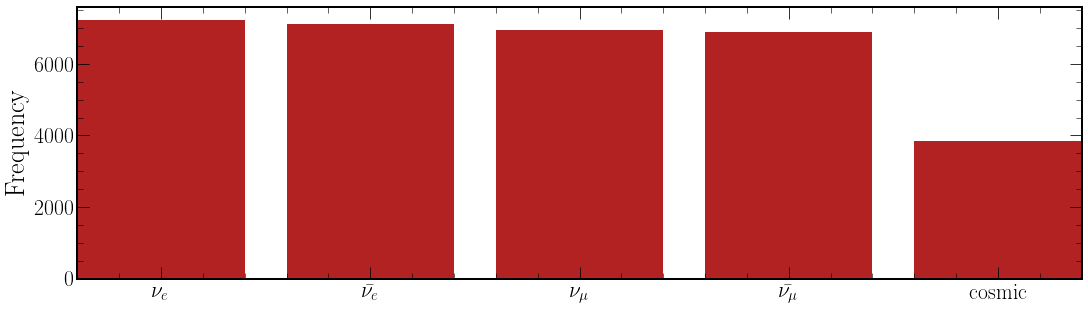

In [10]:
# change variable name for dataframes to make everything easier
events_u = v_cth_uniform_cosmic_events  
events_b = v_cth_flux_cosmic_events

fig, axs = plt.subplots(1, 1, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
cats = np.arange(5)
axs.bar(
    cats, 
    [len(events_b[(events_b.t_nu_type == 0) & (events_b.t_sign_type == 0) & (events_b.t_cosmic_cat == 0)]), 
     len(events_b[(events_b.t_nu_type == 0) & (events_b.t_sign_type == 1) & (events_b.t_cosmic_cat == 0)]), 
     len(events_b[(events_b.t_nu_type == 1) & (events_b.t_sign_type == 0) & (events_b.t_cosmic_cat == 0)]), 
     len(events_b[(events_b.t_nu_type == 1) & (events_b.t_sign_type == 1) & (events_b.t_cosmic_cat == 0)]), 
     len(events_b[events_b.t_cosmic_cat == 1])],
    color="firebrick")
axs.set_xticks(cats)
axs.set_xticklabels(('$\\nu_{e}$', '$\\bar{\\nu_{e}}$', '$\\nu_{\mu}$', '$\\bar{\\nu_{\mu}}$', 'cosmic'))
axs.set_ylabel("Frequency")
plt.show()
plt.savefig('./data/output/histogram.pgf')

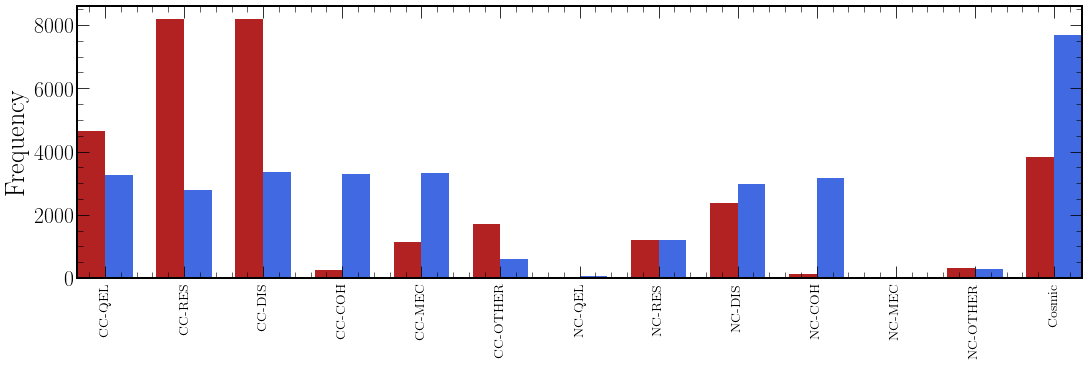

In [11]:
data_u = [len(events_u[events_u[chipsnet.data.MAP_INT_TYPE.name] == i]) for i in range(len(chipsnet.data.MAP_INT_TYPE.labels))]
data_b = [len(events_b[events_b[chipsnet.data.MAP_INT_TYPE.name] == i]) for i in range(len(chipsnet.data.MAP_INT_TYPE.labels))]
cats = np.arange(len(chipsnet.data.MAP_INT_TYPE.labels))
width = 0.35

fig, axs = plt.subplots(1, 1, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
axs.bar(cats+width/2, data_u, color="royalblue", width=width)
axs.bar(cats-width/2, data_b, color="firebrick", width=width)
axs.set_xticks(cats)
axs.set_xticklabels(chipsnet.data.MAP_INT_TYPE.labels, fontsize=14, rotation='vertical')
axs.set_ylabel("Frequency")
plt.show()

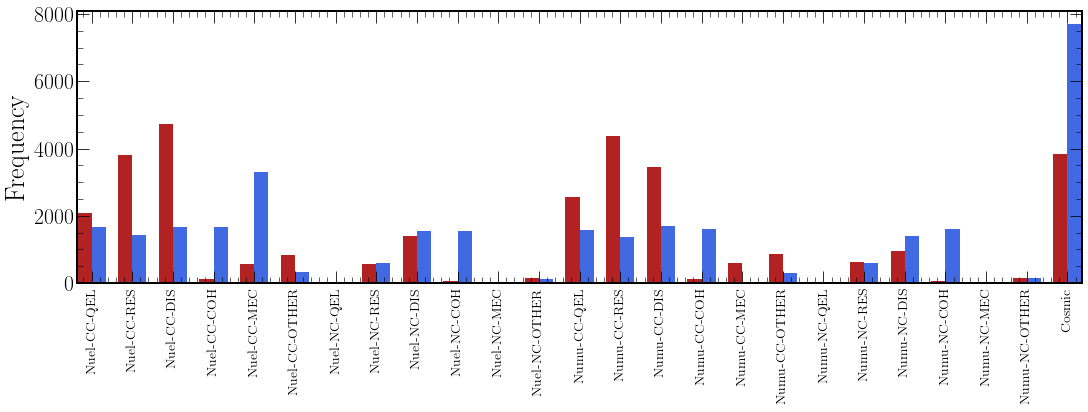

In [12]:
data_u = [len(events_u[events_u[chipsnet.data.MAP_ALL_CAT.name] == i]) for i in range(len(chipsnet.data.MAP_ALL_CAT.labels))]
data_b = [len(events_b[events_b[chipsnet.data.MAP_ALL_CAT.name] == i]) for i in range(len(chipsnet.data.MAP_ALL_CAT.labels))]
cats = np.arange(len(chipsnet.data.MAP_ALL_CAT.labels))
width = 0.35

fig, axs = plt.subplots(1, 1, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
axs.bar(cats+width/2, data_u, color="royalblue", width=width)
axs.bar(cats-width/2, data_b, color="firebrick", width=width)
axs.set_xticks(cats)
axs.set_xticklabels(chipsnet.data.MAP_ALL_CAT.labels, fontsize=14, rotation='vertical')
axs.set_ylabel("Frequency")
plt.show()

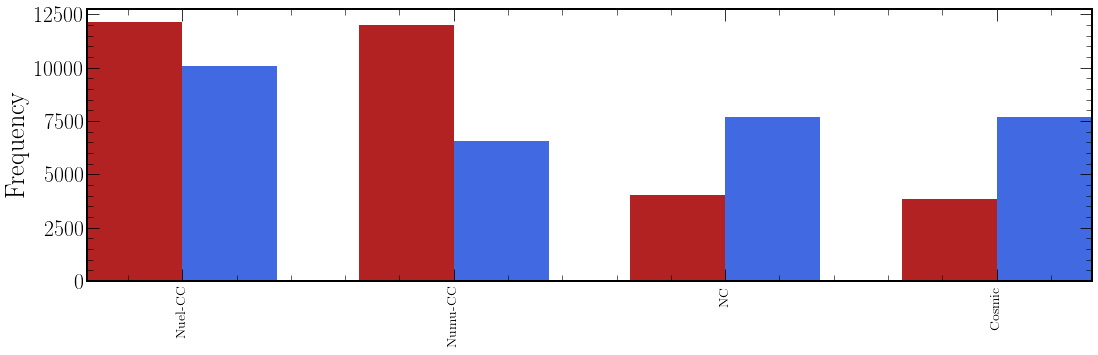

In [13]:
data_u = [len(events_u[events_u[chipsnet.data.MAP_FULL_COMB_CAT.name] == i]) for i in range(len(chipsnet.data.MAP_FULL_COMB_CAT.labels))]
data_b = [len(events_b[events_b[chipsnet.data.MAP_FULL_COMB_CAT.name] == i]) for i in range(len(chipsnet.data.MAP_FULL_COMB_CAT.labels))]
cats = np.arange(len(chipsnet.data.MAP_FULL_COMB_CAT.labels))
width = 0.35

fig, axs = plt.subplots(1, 1, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
axs.bar(cats+width/2, data_u, color="royalblue", width=width)
axs.bar(cats-width/2, data_b, color="firebrick", width=width)
axs.set_xticks(cats)
axs.set_xticklabels(chipsnet.data.MAP_FULL_COMB_CAT.labels, fontsize=14, rotation='vertical')
axs.set_ylabel("Frequency")
plt.show()

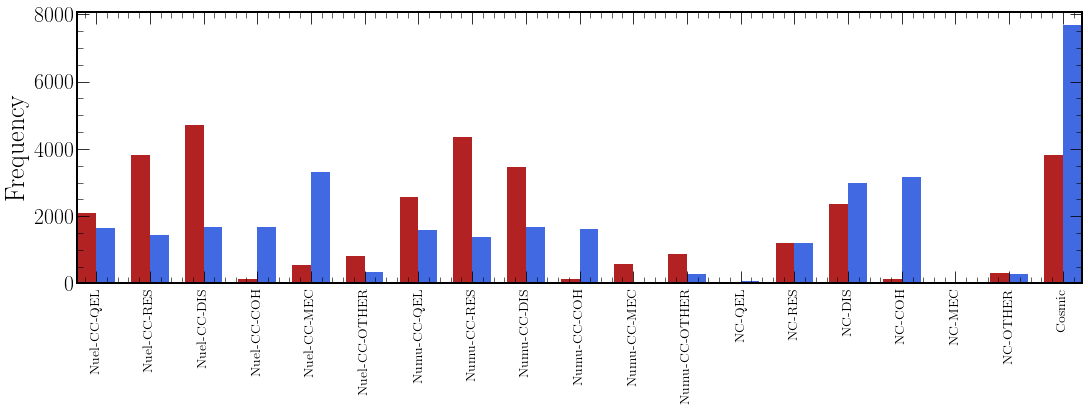

In [14]:
data_u = [len(events_u[events_u[chipsnet.data.MAP_NU_NC_COMB_CAT.name] == i]) for i in range(len(chipsnet.data.MAP_NU_NC_COMB_CAT.labels))]
data_b = [len(events_b[events_b[chipsnet.data.MAP_NU_NC_COMB_CAT.name] == i]) for i in range(len(chipsnet.data.MAP_NU_NC_COMB_CAT.labels))]
cats = np.arange(len(chipsnet.data.MAP_NU_NC_COMB_CAT.labels))
width = 0.35

fig, axs = plt.subplots(1, 1, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
axs.bar(cats+width/2, data_u, color="royalblue", width=width)
axs.bar(cats-width/2, data_b, color="firebrick", width=width)
axs.set_xticks(cats)
axs.set_xticklabels(chipsnet.data.MAP_NU_NC_COMB_CAT.labels, fontsize=14, rotation='vertical')
axs.set_ylabel("Frequency")
plt.show()

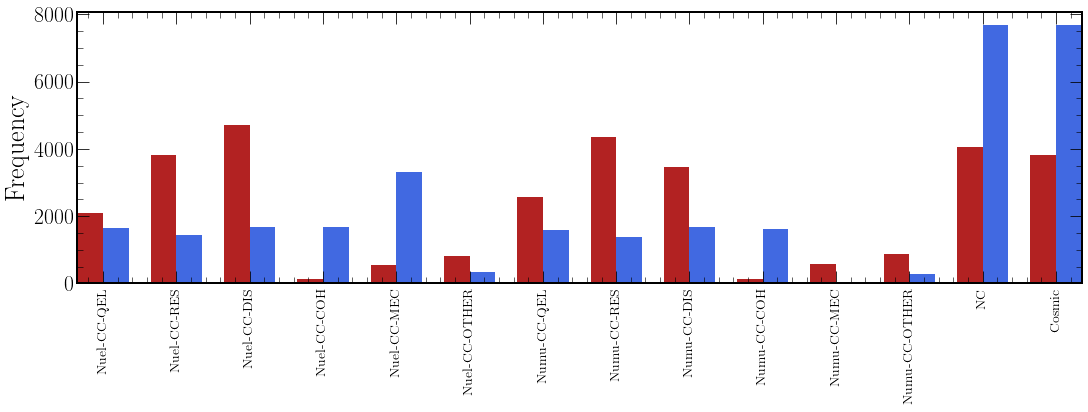

In [15]:
data_u = [len(events_u[events_u[chipsnet.data.MAP_NC_COMB_CAT.name] == i]) for i in range(len(chipsnet.data.MAP_NC_COMB_CAT.labels))]
data_b = [len(events_b[events_b[chipsnet.data.MAP_NC_COMB_CAT.name] == i]) for i in range(len(chipsnet.data.MAP_NC_COMB_CAT.labels))]
cats = np.arange(len(chipsnet.data.MAP_NC_COMB_CAT.labels))
width = 0.35

fig, axs = plt.subplots(1, 1, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
axs.bar(cats+width/2, data_u, color="royalblue", width=width)
axs.bar(cats-width/2, data_b, color="firebrick", width=width)
axs.set_xticks(cats)
axs.set_xticklabels(chipsnet.data.MAP_NC_COMB_CAT.labels, fontsize=14, rotation='vertical')
axs.set_ylabel("Frequency")
plt.show()

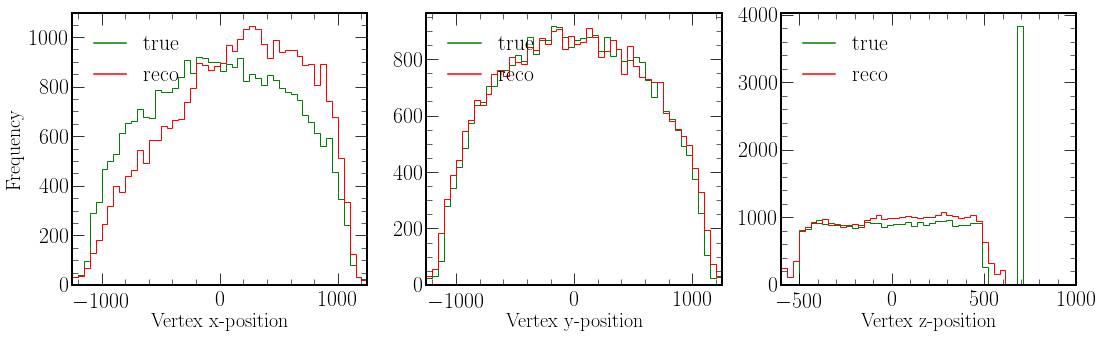

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'hspace': 0.3})

line_g = matplotlib.lines.Line2D([], [], c='green')
line_r = matplotlib.lines.Line2D([], [], c='red')

axs[0].hist(events_b["t_vtxX"], range=(-1250, 1250), bins=50, color='green', histtype='step')
axs[0].hist(events_b["r_vtxX"]*1250, range=(-1250, 1250), bins=50, color='red', histtype='step')
axs[0].legend(loc="upper left", handles=[line_g, line_r], labels=["true", "reco"])
axs[0].set_xlabel('Vertex x-position', fontsize=20)
axs[0].set_ylabel('Frequency', fontsize=20)

axs[1].hist(events_b["t_vtxY"], range=(-1250, 1250), bins=50, color='green', histtype='step')
axs[1].hist(events_b["r_vtxY"]*1250, range=(-1250, 1250), bins=50, color='red', histtype='step')
axs[1].legend(loc="upper left", handles=[line_g, line_r], labels=["true", "reco"])
axs[1].set_xlabel('Vertex y-position', fontsize=20)

axs[2].hist(events_b["t_vtxZ"], range=(-600, 1000), bins=50, color='green', histtype='step')
axs[2].hist(events_b["r_vtxZ"]*600, range=(-600, 1000), bins=50, color='red', histtype='step')
axs[2].legend(loc="upper left", handles=[line_g, line_r], labels=["true", "reco"])
axs[2].set_xlabel('Vertex z-position', fontsize=20)
plt.show()

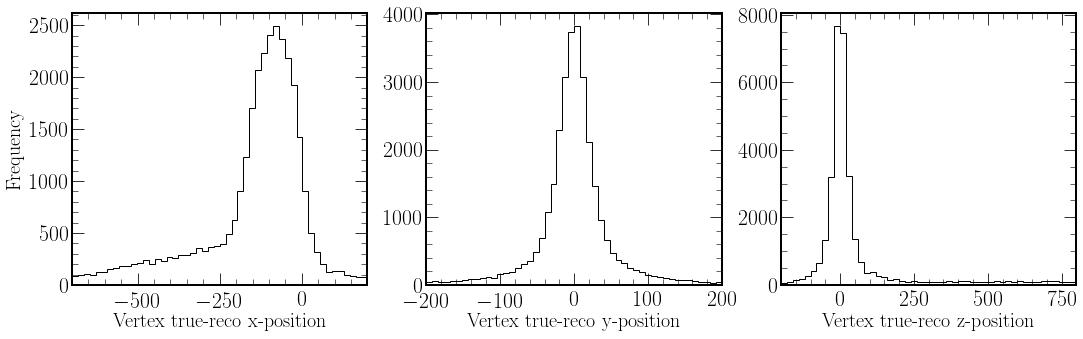

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
axs[0].hist(events_b["t_vtxX"]-(events_b["r_vtxX"]*1250), range=(-700, 200), bins=50, color='black', histtype='step')
axs[0].set_xlabel('Vertex true-reco x-position', fontsize=20)
axs[0].set_ylabel('Frequency', fontsize=20)

axs[1].hist(events_b["t_vtxY"]-(events_b["r_vtxY"]*1250), range=(-200, 200), bins=50, color='black', histtype='step')
axs[1].set_xlabel('Vertex true-reco y-position', fontsize=20)

axs[2].hist(events_b["t_vtxZ"]-(events_b["r_vtxZ"]*600), range=(-200, 800), bins=50, color='black', histtype='step')
axs[2].set_xlabel('Vertex true-reco z-position', fontsize=20)
plt.show()

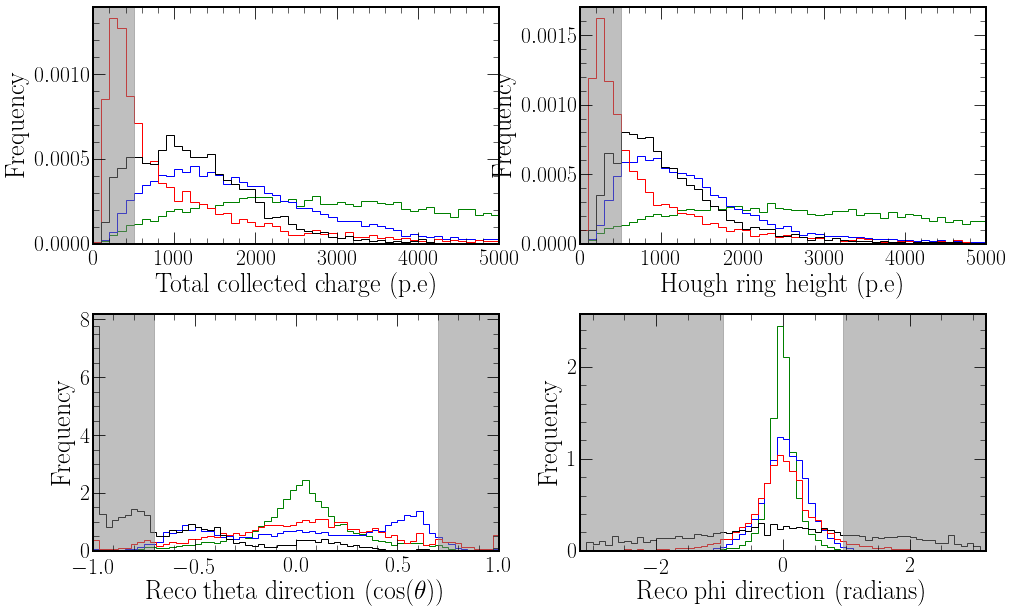

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10), gridspec_kw={'hspace': 0.3})
axs[0, 0].hist(events_b[events_b.t_comb_cat == 0]['r_raw_total_digi_q'], color='green',
               histtype='step', range=(0, 5000), bins=50, density=True)
axs[0, 0].hist(events_b[events_b.t_comb_cat == 1]['r_raw_total_digi_q'], color='blue', 
               histtype='step', range=(0, 5000), bins=50, density=True)
axs[0, 0].hist(events_b[events_b.t_comb_cat == 2]['r_raw_total_digi_q'], color='red', 
               histtype='step', range=(0, 5000), bins=50, density=True)
axs[0, 0].hist(events_b[events_b.t_comb_cat == 3]['r_raw_total_digi_q'], color='black', 
               histtype='step', range=(0, 5000), bins=50, density=True)
axs[0, 0].set(xlabel='Total collected charge (p.e)', ylabel='Frequency')
axs[0, 0].axvspan(0, 500, alpha=0.5, color='grey')

axs[0, 1].hist(events_b[events_b.t_comb_cat == 0]['r_first_ring_height'], color='green',
               histtype='step', range=(0, 5000), bins=50, density=True)
axs[0, 1].hist(events_b[events_b.t_comb_cat == 1]['r_first_ring_height'], color='blue', 
               histtype='step', range=(0, 5000), bins=50, density=True)
axs[0, 1].hist(events_b[events_b.t_comb_cat == 2]['r_first_ring_height'], color='red', 
               histtype='step', range=(0, 5000), bins=50, density=True)
axs[0, 1].hist(events_b[events_b.t_comb_cat == 3]['r_first_ring_height'], color='black', 
               histtype='step', range=(0, 5000), bins=50, density=True)
axs[0, 1].set(xlabel='Hough ring height (p.e)', ylabel='Frequency')
axs[0, 1].axvspan(0, 500, alpha=0.5, color='grey')

axs[1, 0].hist(events_b[events_b.t_comb_cat == 0]['r_dirTheta'], color='green',
               histtype='step', range=(-1, 1), bins=64, density=True)
axs[1, 0].hist(events_b[events_b.t_comb_cat == 1]['r_dirTheta'], color='blue', 
               histtype='step', range=(-1, 1), bins=64, density=True)
axs[1, 0].hist(events_b[events_b.t_comb_cat == 2]['r_dirTheta'], color='red', 
               histtype='step', range=(-1, 1), bins=64, density=True)
axs[1, 0].hist(events_b[events_b.t_comb_cat == 3]['r_dirTheta'], color='black', 
               histtype='step', range=(-1, 1), bins=64, density=True)
axs[1, 0].set(xlabel='Reco theta direction (cos($\\theta$))', ylabel='Frequency')
axs[1, 0].axvspan(-1, -0.7, alpha=0.5, color='grey')
axs[1, 0].axvspan(0.7, 1, alpha=0.5, color='grey')

axs[1, 1].hist(events_b[events_b.t_comb_cat == 0]['r_dirPhi']*180, color='green',
               histtype='step', range=(-3.2, 3.2), bins=64, density=True)
axs[1, 1].hist(events_b[events_b.t_comb_cat == 1]['r_dirPhi']*180, color='blue', 
               histtype='step', range=(-3.2, 3.2), bins=64, density=True)
axs[1, 1].hist(events_b[events_b.t_comb_cat == 2]['r_dirPhi']*180, color='red', 
               histtype='step', range=(-3.2, 3.2), bins=64, density=True)
axs[1, 1].hist(events_b[events_b.t_comb_cat == 3]['r_dirPhi']*180, color='black', 
               histtype='step', range=(-3.2, 3.2), bins=64, density=True)
axs[1, 1].set(xlabel='Reco phi direction (radians)', ylabel='Frequency')
axs[1, 1].axvspan(-3.2, -0.94, alpha=0.5, color='grey')
axs[1, 1].axvspan(0.94, 3.2, alpha=0.5, color='grey')
plt.show()

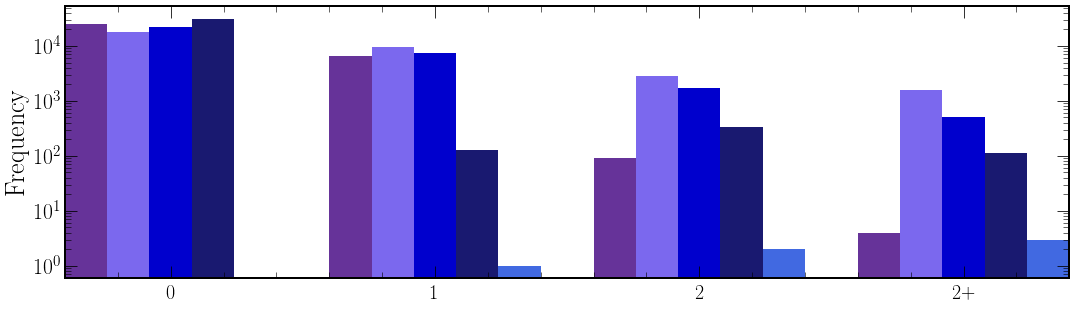

In [19]:
total_data = [len(events_b[events_b["prim_total"] == i]) for i in range(4)]
p_data = [len(events_b[events_b["prim_p"] == i]) for i in range(4)]
cp_data = [len(events_b[events_b["prim_cp"] == i]) for i in range(4)]
np_data = [len(events_b[events_b["prim_np"] == i]) for i in range(4)]
g_data = [len(events_b[events_b["prim_g"] == i]) for i in range(4)]
cats = np.arange(4)
width = 0.8

fig, axs = plt.subplots(1, 1, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
axs.bar(cats-(2*width/5), p_data, color="rebeccapurple", width=width/5)
axs.bar(cats-(width/5), cp_data, color="mediumslateblue", width=width/5)
axs.bar(cats, np_data, color="mediumblue", width=width/5)
axs.bar(cats+(width/5), g_data, color="midnightblue", width=width/5)
axs.bar(cats+(2*width/5), cats, color="royalblue", width=width/5)
axs.set_xticks(cats)
axs.set_xticklabels(("0", "1", "2", "2+"), fontsize=20)
axs.set_ylabel("Frequency")
axs.set_yscale('log')
plt.show()

In [20]:
# Will look at input from beam_all_nuel, beam_all_numu and cosmic_all input files to view all types of events...
nuel_file = "/unix/chips/jtingey/production/beam_all/nuel/map/chips_1200/selected_000_sim_map.root"
numu_file = "/unix/chips/jtingey/production/beam_all/numu/map/chips_1200/selected_000_sim_map.root"
cosmic_file = "/unix/chips/jtingey/production/cosmic_all/map/chips_1200/selected_000_sim_map.root"

# Setup an images dictionary to hold example images
image_size = [64, 64]
images_dict = {
    "r_raw_charge_map_origin": [],
    "r_raw_charge_map_iso": [],
    "r_raw_charge_map_vtx": [],
    "r_raw_time_map_origin": [],
    "r_raw_time_map_iso": [],
    "r_raw_time_map_vtx": [],
    "r_raw_hit_hough_map_vtx": []
}
channel_hists = images_dict

In [21]:
# Load the images into the dictionary
import uproot
nuel_file = uproot.open(nuel_file)
numu_file = uproot.open(numu_file)
cosmic_file = uproot.open(cosmic_file)
for image_name in images_dict.keys():
    images_dict[image_name].extend(nuel_file['reco'].array(image_name))
    images_dict[image_name].extend(numu_file['reco'].array(image_name))
    images_dict[image_name].extend(cosmic_file['reco'].array(image_name))

# Calculate fraction of hits in the endcaps
cap_total = 0
barrel_total = 0
for event in images_dict['r_raw_charge_map_vtx']:
    sections = np.split(event, [18, 46], axis=0)
    cap_total += (sections[0].sum() + sections[2].sum())
    barrel_total += sections[1].sum()

# This is with cosmic events included
print("Fraction of deposited charge in endcaps = {}".format(cap_total/(cap_total+barrel_total)))

Fraction of deposited charge in endcaps = 0.47705780747902665


In [22]:
def plot_hit_time(images_dict, event):
    fig, axs = plt.subplots(2, 3, figsize=(16, 10), gridspec_kw={'hspace': 0.3})
    plt.setp(axs, xticks=[0, 16, 32, 48, 64], yticks=[0, 16, 32, 48, 64])
    axs[0, 0].imshow(images_dict['r_raw_charge_map_origin'][event], cmap='Reds', origin='lower')
    axs[0, 0].set_title('$\phi$ and $\\theta$ from origin')
    axs[0, 0].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins')

    axs[0, 1].imshow(images_dict['r_raw_charge_map_iso'][event], cmap='Reds', origin='lower')
    axs[0, 1].set_title('$x^{+}$ and $x^{-}$ from origin')
    axs[0, 1].set(xlabel='$x^{+}$ bins', ylabel='$x^{-}$ bins')

    axs[0, 2].imshow(images_dict['r_raw_charge_map_vtx'][event], cmap='Reds', origin='lower')
    axs[0, 2].set_title('$\phi$ and $\\theta$ from vertex')
    axs[0, 2].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins')
    axs[0, 2].text(68, 3, 'Desposited charge images', rotation=-90, fontsize=18)

    axs[1, 0].imshow(images_dict['r_raw_time_map_origin'][event], cmap='Reds', origin='lower')
    axs[1, 0].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins')

    axs[1, 1].imshow(images_dict['r_raw_time_map_iso'][event], cmap='Reds', origin='lower')
    axs[1, 1].set(xlabel='$x^{+}$ bins', ylabel='$x^{-}$ bins')

    axs[1, 2].imshow(images_dict['r_raw_time_map_vtx'][event], cmap='Reds', origin='lower')
    axs[1, 2].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins')
    axs[1, 2].text(68, 10, 'First hit time images', rotation=-90, fontsize=18)
    
def plot_hough(images_dict, event):
    fig, axs = plt.subplots(1, 1, figsize=(5, 5), gridspec_kw={'hspace': 0.3})
    plt.setp(axs, xticks=[0, 16, 32, 48, 64], yticks=[0, 16, 32, 48, 64])
    axs.imshow(images_dict['r_raw_hit_hough_map_vtx'][event], cmap='Reds', origin='lower')
    axs.set_title('$\phi$ and $\\theta$ from vertex')
    axs.set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins')
    axs.text(68, 13, 'Hough space image', rotation=-90, fontsize=18)

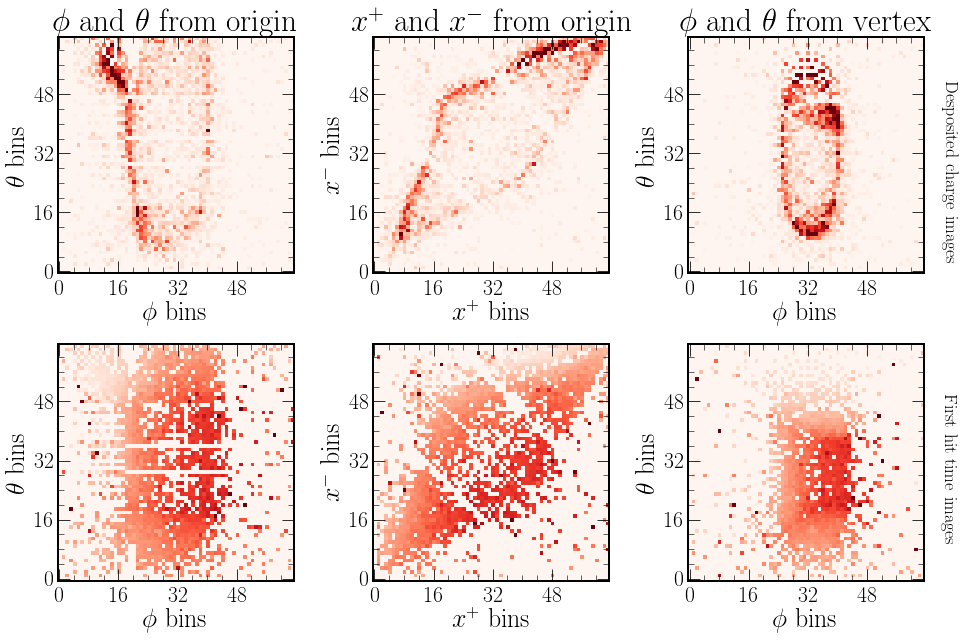

In [23]:
plot_hit_time(images_dict, 1)

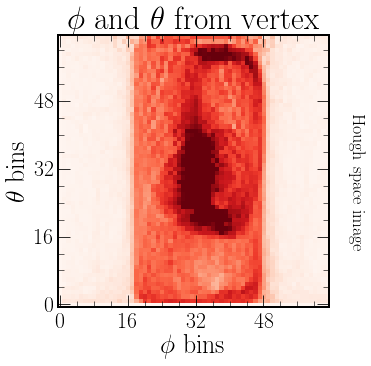

In [24]:
plot_hough(images_dict, 1)

In [25]:
def plot_8bit_range(images_dict, max_charge=30, max_time=130, max_hough=4000):
    fig, axs = plt.subplots(1, 3, figsize=(16, 5))
    #plt.setp(axs, xticks=[0, 16, 32, 48, 64], yticks=[0, 16, 32, 48, 64])
    
    hist_data = []
    for event in images_dict['r_raw_charge_map_vtx']:
        hist_data.append(event.reshape(4096))
    hist_data = np.concatenate(hist_data, axis=0)
    occurrences = np.count_nonzero(hist_data == 255)/len(hist_data)
    axs[0].hist(hist_data, range=(1, 256), bins=255, color='grey', histtype='step')
    axs[0].set_title("[0,{}], outside range: {:.4f}".format(max_charge, occurrences), fontsize=17)
    axs[0].set(xlabel='Hit charge 8-bit value', ylabel='Frequency')
    axs[0].label_outer()
    
    hist_data = []
    for event in images_dict['r_raw_time_map_vtx']:
        hist_data.append(event.reshape(4096))
    hist_data = np.concatenate(hist_data, axis=0)
    occurrences = np.count_nonzero(hist_data == 255)/len(hist_data)
    axs[1].hist(hist_data, range=(1, 256), bins=255, color='grey', histtype='step')
    axs[1].set_title("[0,{}], outside range: {:.4f}".format(max_time, occurrences), fontsize=17)
    axs[1].set(xlabel='Hit time 8-bit value', ylabel='Frequency')
    axs[1].label_outer()
    
    hist_data = []
    for event in images_dict['r_raw_hit_hough_map_vtx']:
        hist_data.append(event.reshape(4096))
    hist_data = np.concatenate(hist_data, axis=0)
    occurrences = np.count_nonzero(hist_data == 255)/len(hist_data)
    axs[2].hist(hist_data, range=(1, 256), bins=255, color='grey', histtype='step')
    axs[2].set_title("[0,{}], outside range: {:.4f}".format(max_hough, occurrences), fontsize=17)
    axs[2].set(xlabel='Hough 8-bit value', ylabel='Frequency')
    axs[2].label_outer()

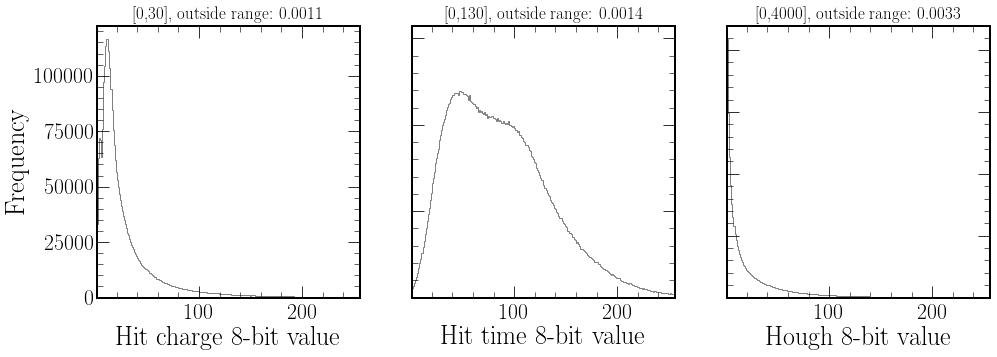

In [26]:
plot_8bit_range(images_dict)

In [28]:
def plot_combined_values(events, prefix):
    bins = 40
    range=(0, 1)
    cat0 = prefix + "pred_t_comb_cat_0"
    cat1 = prefix + "pred_t_comb_cat_1"
    cat2 = prefix + "pred_t_comb_cat_2"
    nuel_cc_events = events[events["t_comb_cat"] == 0]
    numu_cc_events = events[events["t_comb_cat"] == 1]
    nc_events = events[events["t_comb_cat"] == 2]
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
    axs[0].hist(nuel_cc_events[cat0], weights=nuel_cc_events["w"], range=range, bins=bins, color='green', histtype='step')
    axs[0].hist(numu_cc_events[cat0], weights=numu_cc_events["w"], range=range, bins=bins, color='blue', histtype='step')
    axs[0].hist(nc_events[cat0], weights=nc_events["w"], range=range, bins=bins, color='red', histtype='step')
    axs[0].set_xlabel('Combined nuel cc score', fontsize=17)
    axs[0].set_yscale('log')
    
    axs[1].hist(nuel_cc_events[cat1], weights=nuel_cc_events["w"], range=range, bins=bins, color='green', histtype='step')
    axs[1].hist(numu_cc_events[cat1], weights=numu_cc_events["w"], range=range, bins=bins, color='blue', histtype='step')
    axs[1].hist(nc_events[cat1], weights=nc_events["w"], range=(0, 1), bins=bins, color='red', histtype='step')
    axs[1].set_xlabel('Combined numu cc score', fontsize=17)
    axs[1].set_yscale('log')
    
    axs[2].hist(nuel_cc_events[cat2], weights=nuel_cc_events["w"], range=range, bins=bins, color='green', histtype='step')
    axs[2].hist(numu_cc_events[cat2], weights=numu_cc_events["w"], range=range, bins=bins, color='blue', histtype='step')
    axs[2].hist(nc_events[cat2], weights=nc_events["w"], range=range, bins=bins, color='red', histtype='step')
    axs[2].set_xlabel('Combined nc score', fontsize=17)
    axs[2].set_yscale('log')

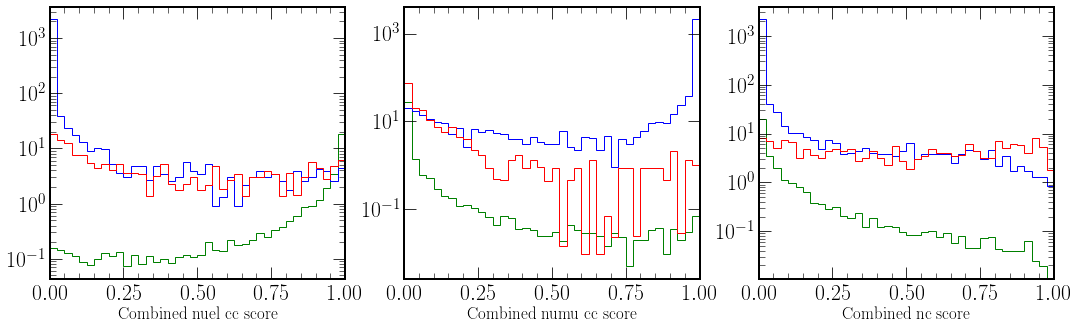

In [30]:
plot_combined_values(v_cth_flux_events[v_cth_flux_events.cut == 0], prefix="bf_")

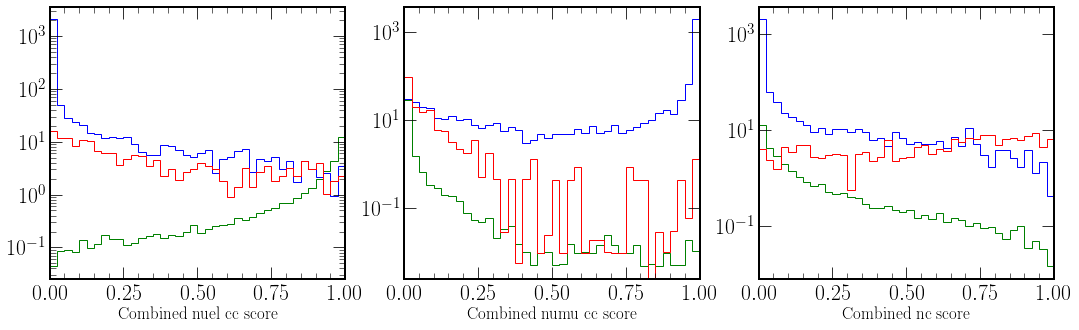

In [31]:
plot_combined_values(v_cth_flux_events[v_cth_flux_events.cut == 0], prefix="bu_")

In [33]:
reload()
cuts, bf_bf_sig_effs, bf_bf_bkg_effs, bf_bf_purities, bf_bf_foms = chipsnet.utils.calculate_curves(
    v_cth_flux_events[v_cth_flux_events.cut == 0], prefix="bf_")
time.sleep(1)
cuts, bf_bu_sig_effs, bf_bu_bkg_effs, bf_bu_purities, bf_bu_foms = chipsnet.utils.calculate_curves(
    v_cth_flux_events[v_cth_flux_events.cut == 0], prefix="bu_")

--- calculating curves: 100%|██████████| 200/200 [00:03<00:00, 58.98it/s]
--- Maximum FOMS ---
Nuel-CC: 0.3651(0.9600)
Numu-CC: 0.9517(0.0800)
NC: 0.4224(0.0750)
Signal efficiency AUC: 0.8952575749172448
Background efficiency AUC: 0.05686161696453171
Purity AUC: 0.23275170371108456
FOM AUC: 0.19421331031171024
ROC AUC: -0.9869456853210775
--- calculating curves: 100%|██████████| 200/200 [00:03<00:00, 59.07it/s]--- Maximum FOMS ---
Nuel-CC: 0.3646(0.9100)
Numu-CC: 0.9524(0.0250)
NC: 0.3913(0.3400)
Signal efficiency AUC: 0.8588157659973412
Background efficiency AUC: 0.06577859011711315
Purity AUC: 0.2415619362153431
FOM AUC: 0.18138433473574422
ROC AUC: -0.9852446325571511



In [44]:
reload()
v_cth_flux_events["classification"] = v_cth_flux_events.apply(chipsnet.utils.classify, axis=1, args=(3, "bf_pred_t_comb_cat_"))
print(classification_report(v_cth_flux_events["t_comb_cat"], v_cth_flux_events["classification"], target_names=["nuel", "numu", "nc"]))

precision    recall  f1-score   support

        nuel       0.91      0.94      0.92     13756
        numu       0.96      0.95      0.95     13645
          nc       0.76      0.70      0.73      4599

    accuracy                           0.91     32000
   macro avg       0.87      0.86      0.87     32000
weighted avg       0.91      0.91      0.91     32000



In [34]:
def plot_combined_values(cuts, sig_effs_bf, sig_effs_bu, bkg_effs_bf, bkg_effs_bu):

    fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'hspace': 0.3})
    axs[0].plot(cuts, sig_effs_bf, color='green')
    axs[0].plot(cuts, bkg_effs_bf, color='red')
    axs[0].plot(cuts, sig_effs_bu, color='green', linestyle='dashed')
    axs[0].plot(cuts, bkg_effs_bu, color='red', linestyle='dashed')
    axs[0].set_xlabel('Combined nuel cc score', fontsize=17)
    axs[0].set_ylabel('Efficiency', fontsize=17)

    axs[1].plot(bkg_effs_bf, sig_effs_bf, color='black')
    axs[1].plot(bkg_effs_bu, sig_effs_bu, color='black', linestyle='dashed')
    axs[1].set_xlabel('Background efficiency', fontsize=17)
    axs[1].set_ylabel('Signal efficiency', fontsize=17)

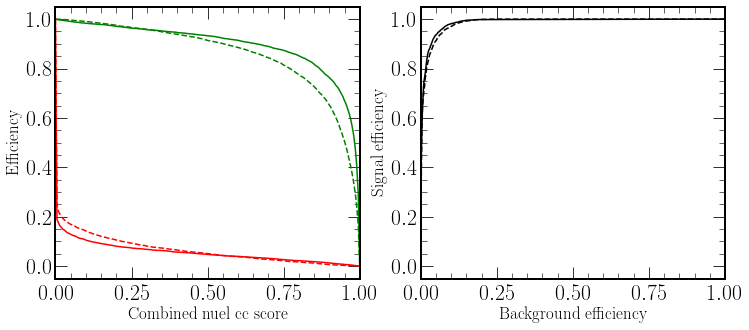

In [35]:
plot_combined_values(cuts, bf_bf_sig_effs[0], bf_bu_sig_effs[0], bf_bf_bkg_effs[0], bf_bu_bkg_effs[0])

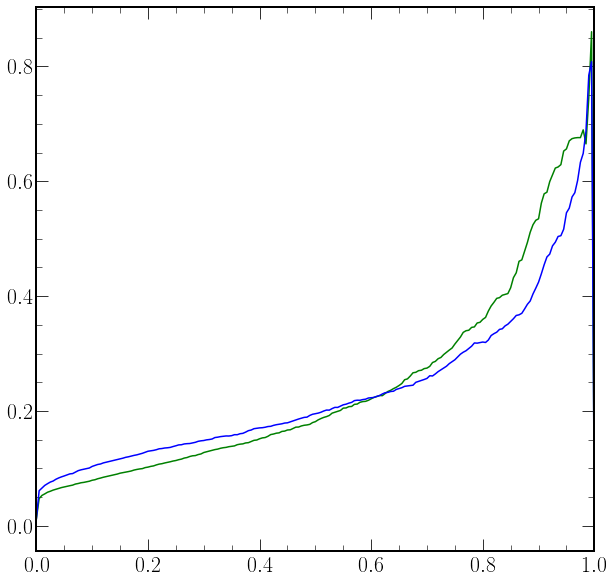

In [37]:
plt.plot(cuts, bf_bu_purities[0], color='green')
plt.plot(cuts, bf_bf_purities[0], color='blue')

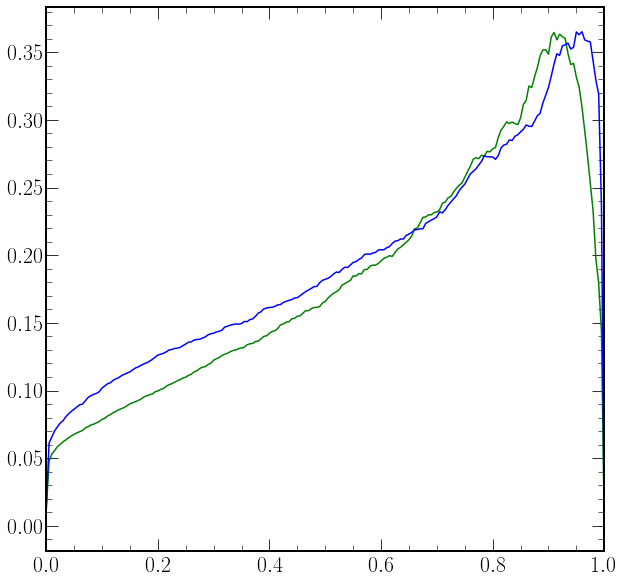

In [38]:
plt.plot(cuts, bf_bu_foms[0], color='green')
plt.plot(cuts, bf_bf_foms[0], color='blue')

## Explainability

In [29]:
from tf_explain.core.grad_cam import GradCAM
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity
from tf_explain.core.activations import ExtractActivations
from tf_explain.core.vanilla_gradients import VanillaGradients
from tf_explain.core.smoothgrad import SmoothGrad
from tf_explain.core.integrated_gradients import IntegratedGradients
from tf_explain.core.gradients_inputs import GradientsInputs


single_output_model = tf.keras.Model(
    inputs=bul_model.model.input,
    outputs=bul_model.model.get_layer('t_all_cat').output
)

grad_cams_1 = []
grad_cams_2 = []
grad_cams_3 = []
occlusions = []
activations_1 = []
activations_2 = []
activations_3 = []
vanilla_grads = []
smooth_grads = []
int_grads = []
imput_grads = []
for inputs, labels in bu_data.testing_ds(20):
    event_class = int(labels['t_all_cat'])
    image = tf.expand_dims(inputs['image_0'], axis=0).numpy()

    if event_class == 24:
        continue

    grad_cams_1.append(GradCAM().explain((image, event_class), single_output_model, class_index=event_class, layer_name="path0_block1"))
    grad_cams_2.append(GradCAM().explain((image, event_class), single_output_model, class_index=event_class, layer_name="path0_block2"))
    grad_cams_3.append(GradCAM().explain((image, event_class), single_output_model, class_index=event_class, layer_name="path0_block3"))
    occlusions.append(OcclusionSensitivity().explain((image, event_class), single_output_model, class_index=event_class, patch_size=3))
    activations_1.append(ExtractActivations().explain((image, event_class), single_output_model, layers_name='path0_block1_conv0'))
    activations_2.append(ExtractActivations().explain((image, event_class), single_output_model, layers_name='path0_block2_conv0'))
    activations_3.append(ExtractActivations().explain((image, event_class), single_output_model, layers_name='path0_block3_conv0'))
    vanilla_grads.append(VanillaGradients().explain((image, event_class), single_output_model, class_index=event_class))
    smooth_grads.append(SmoothGrad().explain((image, event_class), single_output_model, class_index=event_class))
    int_grads.append(IntegratedGradients().explain((image, event_class), single_output_model, class_index=event_class))
    imput_grads.append(GradientsInputs().explain((image, event_class), single_output_model, class_index=event_class))

[Text(0, 0.5, '$\\theta$ bins'),
 Text(0.5, 0, '$\\phi$ bins'),
 Text(0.5, 1.0, 'GradCam Block 3')]

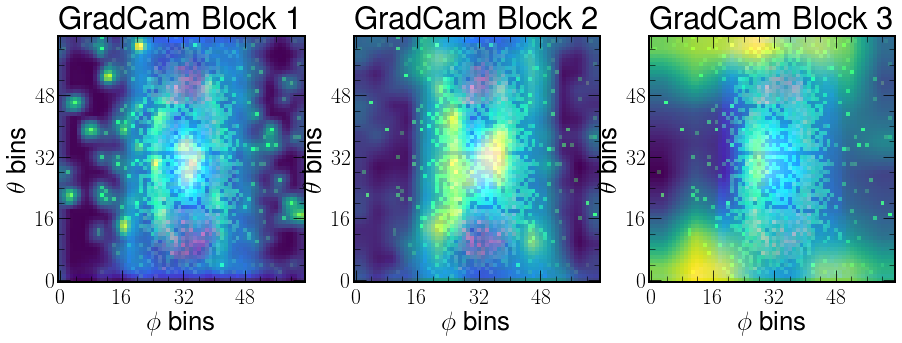

In [33]:
event = 11
fig, axs = plt.subplots(1, 3, figsize=(15, 12), gridspec_kw={'hspace': 0.3})
plt.setp(axs, xticks=[0, 16, 32, 48, 64], yticks=[0, 16, 32, 48, 64])
axs[0].imshow(grad_cams_1[event], cmap='Reds', origin='lower')
axs[0].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 1')
axs[1].imshow(grad_cams_2[event], cmap='Reds', origin='lower')
axs[1].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 2')
axs[2].imshow(grad_cams_3[event], cmap='Reds', origin='lower')
axs[2].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 3')
#axs[1, 0].imshow(smooth_grads[event], cmap='Reds', origin='lower')
#axs[1, 0].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='Smooth gradients')
#axs[1, 1].imshow(int_grads[event], cmap='Reds', origin='lower')
#axs[1, 1].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='Int gradients')
#axs[1, 2].imshow(imput_grads[event], cmap='Reds', origin='lower')
#axs[1, 2].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='Input times gradients')

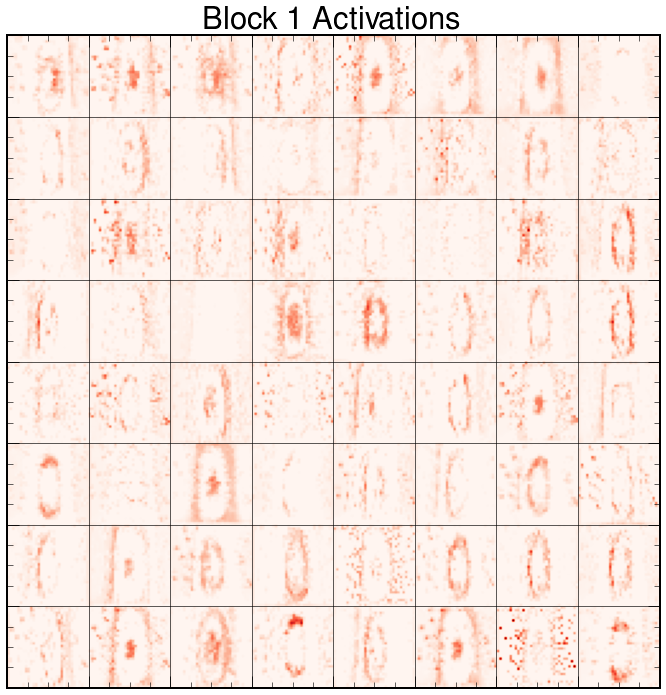

In [99]:
event = 11
fig, axs = plt.subplots(1, 1, figsize=(12, 12))
plt.setp(axs, 
         xticks=[0, 32, 64, 96, 128, 160, 192, 224, 256], xticklabels=[''],
         yticks=[0, 32, 64, 96, 128, 160, 192, 224, 256], yticklabels=[''])
extent = (0, 256, 256, 0)
axs.imshow(activations_1[event], cmap='Reds', origin='lower', extent=extent)
axs.set(title='Block 1 Activations')
plt.rc('grid', linestyle="-", color='black')
plt.grid()
plt.show()

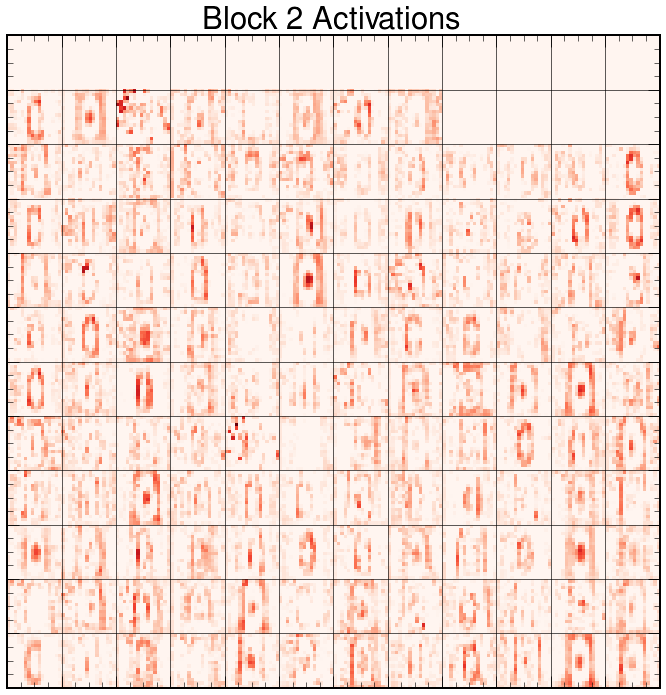

In [100]:
event = 11
fig, axs = plt.subplots(1, 1, figsize=(12, 12))
plt.setp(axs, 
         xticks=[0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192], xticklabels=[''],
         yticks=[0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192], yticklabels=[''])
extent = (0, 192, 192, 0)
axs.imshow(activations_2[event], cmap='Reds', origin='lower', extent=extent)
axs.set(title='Block 2 Activations')
plt.rc('grid', linestyle="-", color='black')
plt.grid()
plt.show()

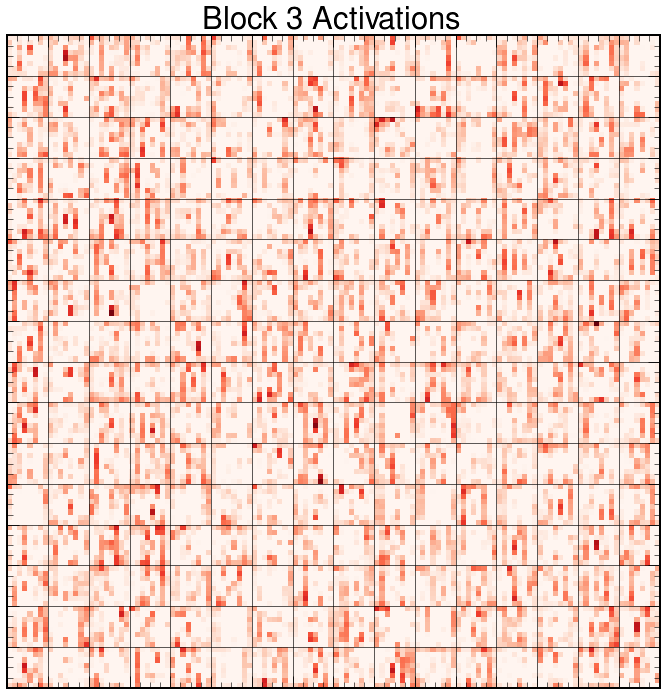

In [101]:
event = 11
fig, axs = plt.subplots(1, 1, figsize=(12, 12))
plt.setp(axs, 
    xticks=[0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128], 
    yticks=[0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128], 
    xticklabels=[''], 
    yticklabels=[''])
extent = (0, 128, 128, 0)
axs.imshow(activations_3[event], cmap='Reds', origin='lower', extent=extent)
axs.set(title='Block 3 Activations')
plt.rc('grid', linestyle="-", color='black')
plt.grid()
plt.show()